<a href="https://colab.research.google.com/github/E-Daniel-Prada/dysgraphia-detection-crnn/blob/main/dysgraphia_detection_crnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Librerías
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, LSTM, Bidirectional, Reshape, Input, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import zipfile
import os
from tensorflow.keras.preprocessing import image
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [5]:
#dimensiones de la imagen de entrada
IMG_HEIGHT, IMG_WIDTH = 128, 128
NUM_CLASSES = 7  # Número de características de disgrafía detectadas
"""
Características:
1. Escritura atípica en relación con el eje vertical, posicion inconsistente o anormal de una letra.
2. Inversiones de los grafemas. Por ejemplo cambiar b por p, entre otras.
3. El tamaño inconsistente de las letras. Este se puede comparar de forma individual o entre palabras
4. Errores ortograficos, a nivel de sintaxis. No se escribe correctamente la palabra.
5. Espaciado atipico en la escritura de palabras y frases.
6. Legibilidad pobre, es decir, no es posible determinar las letras que componen una o varias palabras
7. Palabras abandonadas, es decir, indican "murciela" en vez de "Murcielago"
"""


'\nCaracterísticas:\n1. Escritura atípica en relación con el eje vertical, posicion inconsistente o anormal de una letra.\n2. Inversiones de los grafemas. Por ejemplo cambiar b por p, entre otras.\n3. El tamaño inconsistente de las letras. Este se puede comparar de forma individual o entre palabras\n4. Errores ortograficos, a nivel de sintaxis. No se escribe correctamente la palabra.\n5. Espaciado atipico en la escritura de palabras y frases.\n6. Legibilidad pobre, es decir, no es posible determinar las letras que componen una o varias palabras\n7. Palabras abandonadas, es decir, indican "murciela" en vez de "Murcielago"\n'

In [8]:
# Carga de datos de Google Drive
drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/colab-notebooks/datasets/disgrafia/disgrafia_tags/dataset_disgrafia.zip"
extract_path = "/content/drive/MyDrive/colab-notebooks/datasets/disgrafia/disgrafia_crnn"

# Extraer el ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [9]:
# Verificar cantidad de imagenes del dataset
for class_folder in os.listdir(extract_path):
    class_path = os.path.join(extract_path, class_folder)
    if os.path.isdir(class_path):
        print(f"{class_folder}: {len(os.listdir(class_path))} imágenes")

Low Potential Dysgraphia: 135 imágenes
Potential Dysgraphia: 114 imágenes


In [10]:
# Parámetros de configuración
BATCH_SIZE = 32
IMG_SIZE = (128, 128)
SEED = 42

# Dividir dataset en entrenamiento (80%) y validación (20%)
train_dataset = image_dataset_from_directory(
    extract_path,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_dataset = image_dataset_from_directory(
    extract_path,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 249 files belonging to 2 classes.
Using 200 files for training.
Found 249 files belonging to 2 classes.
Using 49 files for validation.


In [11]:
# Obtener clases
class_names = train_dataset.class_names
print(f"Clases detectadas: {class_names}")


Clases detectadas: ['Low Potential Dysgraphia', 'Potential Dysgraphia']


In [12]:
# Optimizar el rendimiento del dataset para su entrenamiento
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


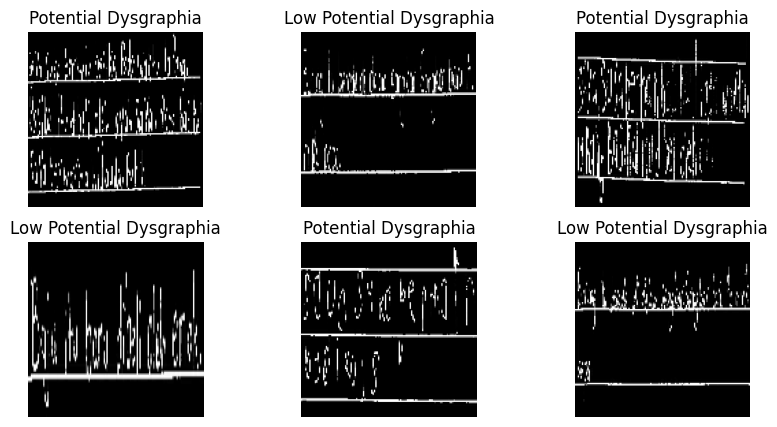

In [13]:
# Visualizar naturaleza de las imagenes
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [14]:
# Modelo CRNN
def build_crnn(input_shape=(128, 128, 3), num_classes=2):
    model = models.Sequential([
        # Bloque CNN - Extrae características espaciales de la imagen.
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Aplanar para LSTM
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Reshape((16, 16)),

        # Capa Recurrente LSTM - Analiza la información secuencial de la imagen.
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(32),

        # Capa completamente conectada - Clasifica entre las dos categorías.
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # 2 clases
    ])

    return model

In [15]:
# Crear el modelo
model = build_crnn()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
# Resumen del modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 16, 64)              │          20,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,551,426 (24.99 MB)

 Trainable params: 6,551,426 (24.99 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Entrenamiento del modelo
EPOCHS = 15

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5202 - loss: 0.6949 - val_accuracy: 0.5306 - val_loss: 0.6688
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5398 - loss: 0.6864 - val_accuracy: 0.5714 - val_loss: 0.6663
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5266 - loss: 0.6870 - val_accuracy: 0.5510 - val_loss: 0.6783
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5667 - loss: 0.6881 - val_accuracy: 0.5306 - val_loss: 0.6931
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.5521 - loss: 0.6953 - val_accuracy: 0.5306 - val_loss: 0.6583
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5624 - loss: 0.6627 - val_accuracy: 0.5714 - val_loss: 0.6500
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5358 - loss: 0.6752 - val_accuracy: 0.5306 - val_loss: 0.6691
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 977ms/step - accuracy: 0.6272 - loss: 0.6565 - val_accuracy: 0.5306 - val_loss: 0.6513
Epoch 

In [19]:
# Graficar precisión y pérdida
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

Text(0.5, 1.0, 'Precisión del modelo')

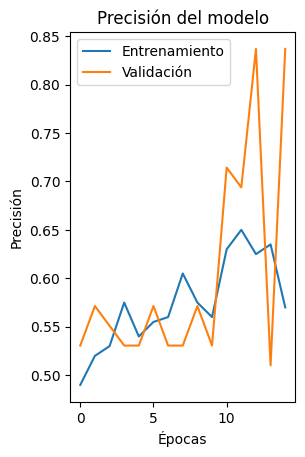

In [20]:
# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Entrenamiento")
plt.plot(history.history["val_accuracy"], label="Validación")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.title("Precisión del modelo")

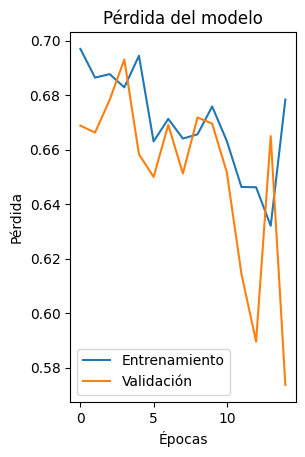

In [21]:
# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.title("Pérdida del modelo")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


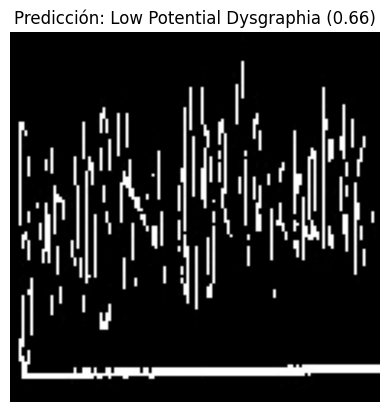

In [22]:
# Ruta de la imagen de prueba en Google Drive
test_image_path = "/content/drive/MyDrive/colab-notebooks/datasets/disgrafia/disgrafia_crnn/Potential Dysgraphia/PD (4).jpg"

# Preprocesar la imagen
img = image.load_img(test_image_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalizar

# Predicción
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]
confidence = np.max(predictions)

# Resultado
plt.imshow(img)
plt.title(f"Predicción: {predicted_class} ({confidence:.2f})")
plt.axis("off")
plt.show()


In [34]:
# Obtener predicciones del modelo
y_pred = model.predict(val_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir a etiquetas

y_true = np.concatenate([y.numpy() for _, y in val_dataset], axis=0)

# Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Matriz de Confusión:\n", conf_matrix)

# Reporte de clasificación
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Reporte de Clasificación:\n", report)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step
Matriz de Confusión:
 [[18  8]
 [14  9]]
Reporte de Clasificación:
                           precision    recall  f1-score   support

Low Potential Dysgraphia       0.56      0.69      0.62        26
    Potential Dysgraphia       0.53      0.39      0.45        23

                accuracy                           0.55        49
               macro avg       0.55      0.54      0.54        49
            weighted avg       0.55      0.55      0.54        49



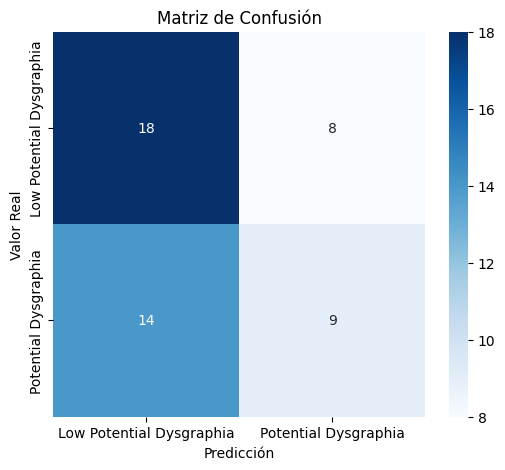

In [35]:
# Configurar el tamaño de la figura
plt.figure(figsize=(6, 5))

# Crear el heatmap con Seaborn
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")

plt.show()